# WGAN Training

## imports

In [1]:
%matplotlib inline

import os
import numpy as np
import matplotlib.pyplot as plt

from models.WGAN import WGAN
from utils.loaders import load_safari, load_cifar10
from keras.preprocessing.image import ImageDataGenerator


Using TensorFlow backend.


In [2]:
RUN_ID = '0024'
RUN_FOLDER = os.path.join("./run", RUN_ID)
DATA_FOLDER = './data/celeb/'

## data

In [ ]:
data_gen = ImageDataGenerator(preprocessing_function=lambda x: (x.astype('float32') - 127.5) / 127.5)

x_train = data_gen.flow_from_directory(DATA_FOLDER
                                         , target_size = (64,64)
                                         , batch_size = 32
                                         , shuffle = True
                                         , class_mode = 'input'
                                         , subset = "training"
                                            )



## architecture

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


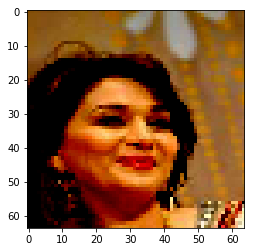

In [4]:
plt.imshow(x_train[0][0][0])

In [5]:
print(np.min(x_train[0][0]))
print(np.max(x_train[0][0]))

-1.0
1.0


In [6]:
#works

gan = WGAN(input_dim = (64,64,3)
        , discriminator_conv_filters = [64,64,128,128]
        , discriminator_conv_kernel_size = [5,5,5,5]
        , discriminator_conv_strides = [2,2,2,1]
        , discriminator_conv_padding = 'same'
        , discriminator_batch_norm_momentum = None
        , discriminator_activation = 'leaky_relu'
        , discriminator_dropout_rate = None
        , discriminator_learning_rate = 0.00005
        , generator_initial_dense_layer_size = (16, 16, 64)
        , generator_use_upsampling = [True,True, False,False]
        , generator_conv_t_filters = [128,64, 64,3]
        , generator_conv_t_kernel_size = [5,5,5,5]
        , generator_conv_t_strides = [1,1,1,1]
        , generator_conv_t_padding = 'same'
        , generator_batch_norm_momentum = 0.8
        , generator_activation = 'leaky_relu'
        , generator_dropout_rate = None
        , generator_learning_rate = 0.00005
        , optimiser = 'rmsprop'
        , z_dim = 100
        )


gan.save(RUN_FOLDER)




In [7]:
#gan.load_weights(os.path.join(RUN_FOLDER, 'weights/weights.h5'))

In [8]:
gan.discriminator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
discriminator_input (InputLa (None, 64, 64, 3)         0         
_________________________________________________________________
discriminator_conv_0 (Conv2D (None, 32, 32, 64)        4864      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 32, 32, 64)        0         
_________________________________________________________________
discriminator_conv_1 (Conv2D (None, 16, 16, 64)        102464    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 16, 16, 64)        0         
_________________________________________________________________
discriminator_conv_2 (Conv2D (None, 8, 8, 128)         204928    
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 8, 8, 128)         0         
__________

/Users/davidfoster/.virtualenvs/gdl/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


In [9]:
gan.generator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
generator_input (InputLayer) (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 16384)             1654784   
_________________________________________________________________
batch_normalization_1 (Batch (None, 16384)             65536     
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 16384)             0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 16, 16, 64)        0         
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 32, 32, 64)        0         
_________________________________________________________________
generator_conv_t_0 (Conv2DTr (None, 32, 32, 128)       204928    
__________

## training

In [ ]:
d_losses, g_losses, d_accs, g_accs = gan.train(     
    x_train
    , batch_size = 32
    , epochs = 2000
    , run_folder = RUN_FOLDER
    , print_every_n_batches = 10
    , initial_epoch = 0
    , n_critic = 5
    , clip_threshold = 0.01
    , using_generator =True
)

In [ ]:
idx = np.random.randint(0, x_train.shape[0], 1)[0]
gan.discriminator.predict(np.array([x_train[idx]]))

In [ ]:
noise = np.random.normal(0, 1, (1, gan.z_dim))
gen_imgs = gan.generator.predict(noise)
gan.discriminator.predict(np.array([gen_imgs[0]]))

In [ ]:
gan.train_discriminator(x_train, batch_size = 32, clip_threshold = 0.01)

In [ ]:
fake = np.ones((128,1))
noise = np.random.normal(0, 1, (128, 100))
gen_imgs = gan.generator.predict(noise)
gan.discriminator.train_on_batch(gen_imgs, fake)

In [ ]:
[(np.min(x), np.max(x)) for x in gan.discriminator.get_weights()]

In [ ]:
gan.train_generator(batch_size = 128)

In [ ]:
[np.round((np.min(x), np.max(x)), 4) for x in gan.generator.get_weights()]

In [ ]:
plt.imshow(np.clip((x[200]+1)*0.5,0,1))

In [ ]:
gan.discriminator.predict(x)

In [ ]:
plt.plot(g_accs, color='orange', linewidth=1)
plt.plot([x[0] for x in d_accs], color='green', linewidth=1)
plt.plot([x[1] for x in d_accs], color='blue', linewidth=1)



In [ ]:
plt.plot(g_losses, color='orange', linewidth=1)
plt.plot([x[0] for x in d_losses], color='green', linewidth=1)
plt.plot([x[1] for x in d_losses], color='blue', linewidth=1)


In [ ]:
for i in range(100):
    print(gan.discriminator.predict(np.array([x_train[i]]))[0])

In [ ]:
noise = np.random.normal(0, 1, 100)
img = gan.generator.predict(np.array([noise]))[0]

print(img.shape)
plt.imshow(np.clip((img+1)*0.5,0,1))

gan.discriminator.predict(np.array([img]))[0]

In [ ]:
len(gan.discriminator.get_weights())

In [ ]:
gan.generator.get_weights()

In [ ]:
gan.discriminator.layers

In [ ]:
pointer = 0
for x, y in enumerate(gan.discriminator.layers):
    
    print(y)
    print(y.trainable)
    for i in gan.discriminator.layers[x].get_weights():
        
        print(pointer)
        print(i.shape)
        pointer+=1
        
        

In [ ]:
len(gan.discriminator.get_weights())

In [ ]:
gan.discriminator.get_weights()[2]

In [ ]:
gan.discriminator.get_weights()[22]

In [ ]:
x_train[0][16]

In [ ]:
gan.model.save_weights(os.path.join(RUN_FOLDER, 'weights/weights.h5'))